In [1]:
from notebook_helper import *
from helpers import la, space, viz
notebook_setup()
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

# Pollution cluster analysis

The goal of this analysis is to use BEIS measures of the emissions under a local authorities control (the subset dataset) to:

1. Determine for each council which other councils are most similar. 
2. Group councils into clusters that explain broadly the problem of their emissions and why they are similar. 

This first attempt uses as dimensions the five grand totals for Industry, Commerical, Domestic, Public Sector, Transport.  

The data is conformed to the current 2021 local authorities, and reduced to just principal authorities.

Although the data has some higher level authorities, their totals are then recreated using the sum of their constituent parts. 

All authorities are then divided by the 2020 population to get a per capita figure. Go back and forth on if this is a good idea, but essentally lets us isolate the question of 'big' authorities for a seperate comparison system. 

In [2]:
data_year = 2019

df = pd.read_excel(Path("data", "2005-19_UK_local_and_regional_CO2_emissions.xlsx"),
                   sheet_name="Subset dataset", header=1)
df = df.loc[df["Year"] == data_year].loc[~df["Code"].isna()]

used_cols = ["Industry Total", "Commercial Total", "Domestic Total", "Public Sector Total", "Transport Total"]

df = df[["Code"] + used_cols]

# transform to principal modern councils
df = (df
      .la.create_code_column(from_type="gss", source_col="Code")
      .drop(columns=["Code"])
      .la.to_current()
      .la.just_principals())

higher_df = df.la.to_higher(aggfunc="sum")

df = pd.concat([df, higher_df])

original_df = df.copy()

df = df.la.get_council_info(["region", "pop_2020"])

#convert to per capita emissions
for c in used_cols:
      df[c] = (df[c]/df["pop_2020"])*100

df = df.drop(columns=["pop_2020"])
df["region"] = df["region"].fillna("Unknown")
df = df.set_index("local-authority-code")
df.head()

,Industry Total,Commercial Total,Domestic Total,Public Sector Total,Transport Total,region
local-authority-code,,,,,,
ABC,0.202964,0.018739,0.176830,0.004395,0.201933,Northern Ireland
ABD,0.118983,0.037371,0.184972,0.008194,0.240239,Scotland
ABE,0.066342,0.067903,0.149283,0.042369,0.142631,Scotland
ADU,0.029168,0.023936,0.126134,0.006697,0.145878,South East
AGB,0.126624,0.052611,0.188899,0.018173,0.213968,Scotland


## Comparsions to physical distance

Comparing the distance between all councils (where the input variables are normalised so there is a mean of 0 and a SD of 1) to the physical distance between councils there is very little agreement on the closest councils. 

The table below shows the agreement between councils in a top k comparison (where k = 1 is the nearest council, k = 10 is the nearest 10 councils). There is on average only a 11% agreement in the top 25 councils. 

In [3]:
relevant_cols = ["Industry Total", "Commercial Total", "Domestic Total", "Public Sector Total", "Transport Total"]
pol_distance = df.space.self_distance("local-authority-code", relevant_cols, normalize=True)

pol_distance.to_csv(Path("data","outputs","council_clusters_v1_distance.csv"), index=False)

real_distance = pd.read_csv(Path("data", "outputs", "geographic_distance.csv" ))

jd = space.join_distance({"pollution_distance": pol_distance,
                         "real_distance": real_distance})
jd.joint_space.agreement()


,top_k,agreement
0,1,0.01
1,2,0.02
2,3,0.03
3,5,0.04
4,10,0.06
5,25,0.11


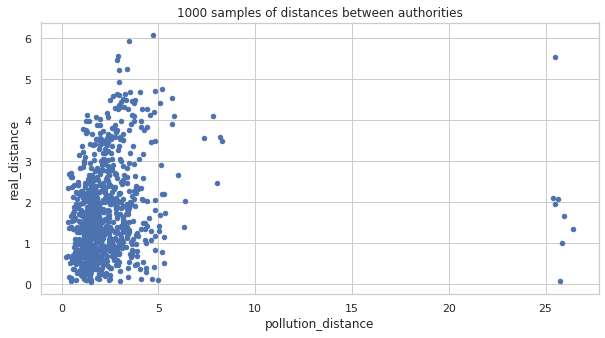

In [4]:
plot = jd.joint_space.plot(sample=1000, title="1000 samples of distances between authorities")

There is Similar dispersal of distances, but no clear pattern (although not many far away, and *also* similar pollution).
Remember all the coordinates were normalised before use, so this is *distance* between spaces on normalised dimensions. 
This also shows that some councils can have quite a high pollution distance, but be very *close*. This validates the general approach of exploring alternatives to distance. 


## Clustering

Using k means clustering, this section tries to group local authorities into a set of clusters of different profiles of emissions. 

Because this has been adjusted per capita, the City of London gets very high numbers, and so fits badly into other clusters. It is dropped from these purposes (or can be said to be a cluster of 1). 

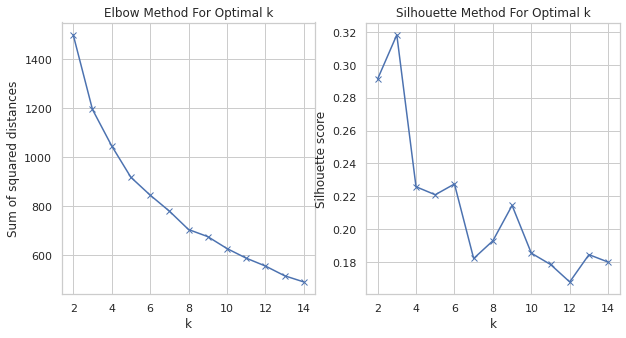

In [5]:
# drop london because it ends up on its own anyway and distorts the scores
cdf = df.drop(index=["LND"]).reset_index()
cluster = space.Cluster(cdf, "local-authority-code", cols = relevant_cols, label_cols=["region"], normalize=True)
cluster.find_k(2,15)

# Chosing 6 clusters 

The relatively slow decent reflects that there is not clear clusters in the data, cloosing 6 as a high point in the silhouette score.

In [6]:
# Choosing 6 clusters, but in general this isn't that much different. Data is not clearly clustered.
cluster.set_k(6)

nice_name_lookup = la.get_la_df().set_index("local-authority-code")["official-name"].to_dict()
stats = cluster.stats(label_lookup=nice_name_lookup)
stats

,count,%,random members
labels,,,
1,122,30.1,"[East Lothian Council, East Riding of Yorkshir..."
2,165,40.7,"[London Borough of Croydon, Midlothian Council..."
3,43,10.6,"[North Ayrshire Council, Comhairle nan Eilean ..."
4,7,1.7,"[London Borough of Camden, City of Westminster..."
5,2,0.5,"[Warwickshire County Council, Gloucestershire ..."
6,66,16.3,"[Liverpool City Council, City of Cardiff Counc..."


Broadly, this splits the data into three 'Mainstream' categories, and three 'Outlier' categories. Where the majority are in the mainstream categories, and the outliers are generally better defined (but much smaller) clustesr. 

Using the label and raincloud tool, descriptions were created of how these labels relate to the variables being grouped. 

In [7]:
# examine variables individually
cluster.raincloud_tool()

interactive(children=(Dropdown(description='variable', options=('Industry Total', 'Commercial Total', 'Domesti…

In [8]:
cluster.label_tool()

interactive(children=(Dropdown(description='cluster', options=(1, 2, 3, 4, 5, 6), value=1), Dropdown(descripti…

In [9]:
cluster.assign_name(n=1, name="Mainstream B", desc="Above average industry/transport/domestic")
cluster.assign_name(n=2, name="Mainstream A", desc="Below average commerical/industry/transport/domestic")
cluster.assign_name(n=3, name="Outlier A", desc="Above average transport, industry, domestic")
cluster.assign_name(n=4, name="Outlier B", desc="Above average commerical/public sector")
cluster.assign_name(n=5, name="Outlier C", desc="Very above average domestic and transport")
cluster.assign_name(n=6, name="Mainstream C", desc="Above average commerical/public sector, below average transport/domestic")
cluster.stats(label_lookup=nice_name_lookup)

,count,%,random members
labels,,,
1: Mainstream B,122,30.1,"[Wychavon District Council, North Devon Distri..."
2: Mainstream A,165,40.7,"[Blaenau Gwent County Borough Council, Erewash..."
3: Outlier A,43,10.6,"[Powys County Council, Ribble Valley Borough C..."
4: Outlier B,7,1.7,"[Clackmannanshire Council, Cambridge City Coun..."
5: Outlier C,2,0.5,"[Warwickshire County Council, Gloucestershire ..."
6: Mainstream C,66,16.3,"[Preston City Council, Trafford Metropolitan B..."


In [13]:
#export with pre per-capita numbers

ldf = cluster.df_with_labels().set_index("local-authority-code")
ldf = ldf[["label", "label_desc"]]
ndf = original_df.copy().set_index("local-authority-code")
ndf = ndf.join(ldf, how="left").reset_index()
ndf = ndf.la.get_council_info(["official-name", "local-authority-type-name"])
ndf.to_csv(Path("data", "outputs", "council_clusters_v1.csv"), index=False)

## Is there any benefit to increasing the number of variables?

The `pollution.ks` notebook explores using *all* the sub-variables. Broadly this produces a set of coherent clusters, but still has the same gradual decline and puts most councils in a single mainstream category. The approach in this notebook is preferable for the moment. 